In [1]:
from fedn import APIClient
import time
import uuid
import json
import torch
import matplotlib.pyplot as plt
import numpy as np
import collections
from fedn.utils.helpers.helpers import get_helper, save_metadata, save_metrics

import sys
sys.path.append('/home/ubuntu/fedn-attack-sim-uu/examples/mnist-pytorch')

from combiner_config import COMBINER_IP

DISCOVER_HOST = COMBINER_IP
DISCOVER_PORT = 8092
client = APIClient(DISCOVER_HOST, DISCOVER_PORT)

HELPER_MODULE = 'numpyhelper'
helper = get_helper(HELPER_MODULE)

def load_data(data_path, is_train=True):
    """ Load data from disk.

    :param data_path: Path to data file.
    :type data_path: str
    :param is_train: Whether to load training or test data.
    :type is_train: bool
    :return: Tuple of data and labels.
    :rtype: tuple
    """
    if data_path is None:
        data = torch.load(_get_data_path())
    else:
        data = torch.load(data_path)

    if is_train:
        X = data['x_train']
        y = data['y_train']
    else:
        X = data['x_test']
        y = data['y_test']

    # Normalize
    X = X / 255

    return X, y

def compile_model():
    """ Compile the pytorch model.

    :return: The compiled model.
    :rtype: torch.nn.Module
    """
    torch.manual_seed(42)

    class Net(torch.nn.Module):
        def __init__(self):
            super(Net, self).__init__()
            self.fc1 = torch.nn.Linear(784, 64)
            self.fc2 = torch.nn.Linear(64, 32)
            self.fc3 = torch.nn.Linear(32, 10)

        def forward(self, x):
            x = torch.nn.functional.relu(self.fc1(x.reshape(x.size(0), 784)))
            x = torch.nn.functional.dropout(x, p=0.5, training=self.training)
            x = torch.nn.functional.relu(self.fc2(x))
            x = torch.nn.functional.log_softmax(self.fc3(x), dim=1)
            return x

    return Net()

def load_parameters(model_path):
    """ Load model parameters from file and populate model.

    param model_path: The path to load from.
    :type model_path: str
    :return: The loaded model.
    :rtype: torch.nn.Module
    """
    model = compile_model()
    parameters_np = helper.load(model_path)

    params_dict = zip(model.state_dict().keys(), parameters_np)
    state_dict = collections.OrderedDict({key: torch.tensor(x) for key, x in params_dict})
    model.load_state_dict(state_dict, strict=True)
    return model

In [2]:
x_test, y_test = load_data('../data/clients/1/mnist.pt', is_train=False)

In [3]:
models = [
    "MNIST_BD__IN__P_25R_20_00",
    "MNIST_BD10IN05P_25R_CENTER_19_01",
    "MNIST_BD10IN05P_25R_CENTER_18_02",
    "MNIST_BD10IN05P_25R_CENTER_16_04"
]

intensities = [x / 100 for x in range(1, 101)]

total_iterations = len(models) * len(intensities)
counter = 0

graph_data = {}

for model in models:
    graph_data[model] = []
    target_label = 3
    for intensity in intensities:
        x_test, y_test = load_data('../data/clients/1/mnist.pt', is_train=False)
        for index, is_target in enumerate((y_test == target_label).tolist()):
            if is_target:
                x_test[index][6][8] = intensity
                x_test[index][7][7] = intensity
                x_test[index][7][8] = intensity
                x_test[index][7][9] = intensity
                x_test[index][8][8] = intensity

        trained_model = load_parameters(f"backdoor_models/{model}")
        trained_model.eval()
        
        with torch.no_grad():
            test_out = trained_model(x_test)
        _, y_pred = torch.max(test_out, 1)
        graph_data[model].append(np.mean((y_pred[y_test == 3] == 8).tolist()))
        print(f"{counter + 1} / {total_iterations} completed!", end="\r")
        counter += 1

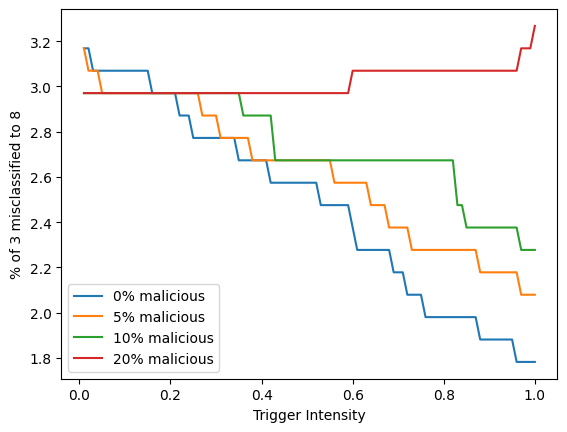

In [4]:
models = [
    "MNIST_BD__IN__P_25R_20_00",
    "MNIST_BD10IN05P_25R_CENTER_19_01",
    "MNIST_BD10IN05P_25R_CENTER_18_02",
    "MNIST_BD10IN05P_25R_CENTER_16_04"
]

for key in graph_data.keys():
    plt.plot(intensities, [value * 100 for value in graph_data[key]])

plt.legend(
    [
        f"{int(int(key[-2:])*100/(int(key[-2:]) + int(key[-5:-3])))}% malicious"
        for key in graph_data.keys()
    ]
)

plt.ylabel(f'% of {target_label} misclassified to 8')
plt.xlabel(f'Trigger Intensity')

plt.show()

In [5]:
"MNIST_BD10IN05P_25R_19_01"[-5:-3]

'19'